# Python EDA & GBTRegrssion Evaluation

### Imports

In [1]:
import os
import glob
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

### Helper Functions

In [2]:
# Confusion Matrix to DataFrame
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

### Read "pre_process" and GBTRegressor results tables

In [3]:
cols = ["taxi_time", "delay_time", "cancelled", "year", "month", "day_of_month", "day_of_week", "fl_date", "weekday", 
         "x_fl_date_moy", "y_fl_date_moy", "x_fl_date_woy", "y_fl_date_woy", "x_fl_date_dow", "y_fl_date_dow", "unique_carrier", 
         "fl_num", "taxi_ind", "delay_ind", "origin", "dest", "dep_del15", "arr_del15", "arr_delay_group", "dep_delay_group", 
         "x_whls_on_mod", "y_whls_on_mod", "x_whls_off_mod", "y_whls_off_mod", "flights", "distance", "distance_group", 
         "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay", "delay_cause"]

tag = "b01ef54a-72a7-49a8-8cd1-48b958b0cf62.csv"
df1 = pd.read_csv("pre_process/pre_process.csv/part-00000-"+tag, names=cols)
df2 = pd.read_csv("pre_process/pre_process.csv/part-00001-"+tag, names=cols)
frames = [df1, df2]
ppdf = pd.concat(frames)
ppdf["taxi_time15_ind"] = ppdf["taxi_time"] > 30
ppdf["route"] = ppdf["origin"] + " to " + ppdf["dest"]
gbtdf = pd.read_csv("gbt/gbt.csv/gbt.csv", names=["label", "prediction"])

### Plots

In [6]:
taxi_time15_ind = ppdf[["taxi_time15_ind", "delay_cause","route"]]
time15_ind = taxi_time15_ind.groupby(['delay_cause', 'route'])['taxi_time15_ind'].sum().reset_index()
time15_ind_filter = time15_ind[time15_ind["taxi_time15_ind"] > 600]["route"]
taxi_filtered = time15_ind[time15_ind['route'].isin(time15_ind_filter)]
taxi_del_ind_df3 = taxi_filtered.pivot("delay_cause", 'route', "taxi_time15_ind")

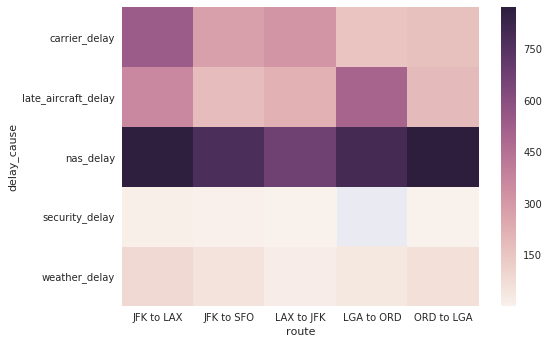

In [8]:
ax = sns.heatmap(taxi_del_ind_df3)

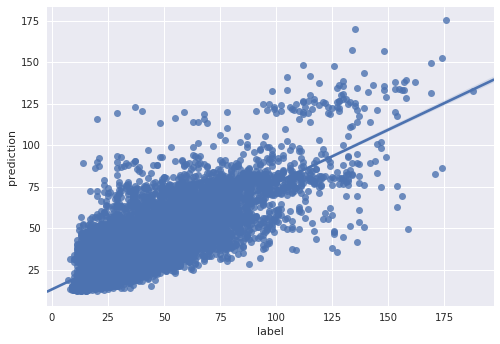

In [8]:
ax = sns.regplot(x="label", y="prediction", data=gbtdf)

In [19]:
bins = [0, 7.0, 20.0, 33.0, 46.0, 59.0, 72.0, 85.0, 98.0, 111.0, 124.0, 137.0, 150.0, 163.0, 176.0, float("inf")]
group_names = ['0-7', '7-20', '20-33', '33-46', '46-59', '59-72', '72-85', '85-98', '98-111', '111-124', '124-137',
              '137-150', '150-163', '163-176', '176-Inf']
gbtdf['label_cats'] = pd.cut(gbtdf['label'], bins, labels=group_names)
gbtdf['pred_cats'] = pd.cut(gbtdf['prediction'], bins, labels=group_names)
from sklearn.metrics import classification_report, confusion_matrix
res = gbtdf
print(classification_report(gbtdf['label_cats'],gbtdf['pred_cats'],target_names=group_names))

cm = confusion_matrix(gbtdf['label_cats'],gbtdf['pred_cats'])
cm2df(cm, group_names)

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0-7       0.00      0.00      0.00         1
       7-20       0.20      0.13      0.16        78
      20-33       0.35      0.19      0.25        72
      33-46       0.08      0.05      0.06        20
      46-59       0.00      0.00      0.00        15
      59-72       0.50      0.17      0.25         6
      72-85       0.00      0.00      0.00         1
      85-98       0.54      0.67      0.60      7350
     98-111       0.37      0.45      0.40      4276
    111-124       0.32      0.38      0.35      2471
    124-137       0.32      0.23      0.27      1364
    137-150       0.75      0.34      0.46      4174
    150-163       0.22      0.21      0.22       609
    163-176       0.17      0.07      0.10       287
    176-Inf       0.19      0.03      0.06       146

avg / total       0.49      0.46      0.46     20870



,0-7,7-20,20-33,33-46,46-59,59-72,72-85,85-98,98-111,111-124,124-137,137-150,150-163,163-176,176-Inf
0-7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7-20,0,10,8,3,0,0,0,0,1,6,5,0,32,12,1
20-33,0,10,14,2,1,1,0,0,4,6,3,0,21,8,2
33-46,0,3,5,1,1,0,0,0,0,1,0,0,3,3,3
46-59,0,2,5,4,0,0,0,0,0,1,2,0,1,0,0
59-72,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0
72-85,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
85-98,0,1,0,0,0,0,0,4947,1591,301,38,451,12,9,0
98-111,0,2,0,0,0,0,0,1487,1910,707,107,20,35,8,0
111-124,0,3,0,0,0,0,0,229,990,942,239,0,58,9,1


In [ ]:
df = pd.read_csv("gbt/gbt.csv/part-00000-d81cbfc1-150d-4ca4-a066-c4a07f8e9892.csv", names=["label", "prediction"])

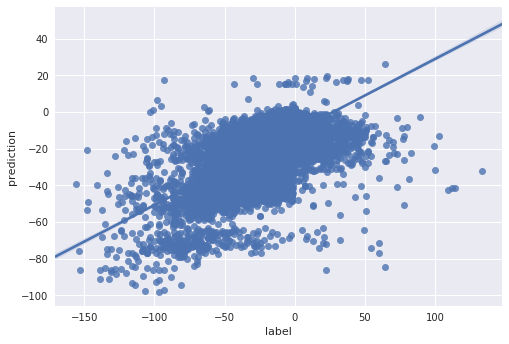

In [8]:
# Regression Plot
ax = sns.regplot(x="label", y="prediction", data=df)

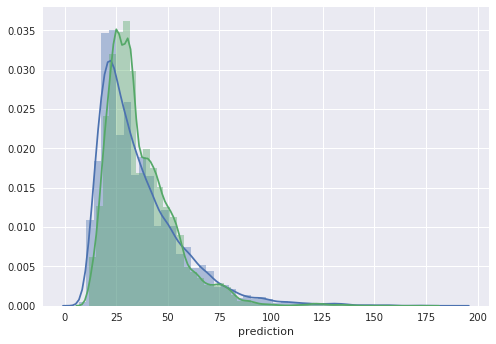

In [10]:
ax1 = sns.distplot(gbtdf["label"])
ax2 = sns.distplot(gbtdf["prediction"]) #green

In [24]:
ax = sns.distplot(time15_ind["taxi_time15_ind"])

NameError: name 'time15_ind' is not defined

In [ ]:
dep_del15_ind = ppdf[["dep_del15", "delay_cause","dep_delay_group"]].rename(columns = {'dep_del15':'del15'})
arr_del15_ind = ppdf[["arr_del15", "delay_cause", "unique_carrier"]].rename(columns = {'arr_del15':'del15'})
del15_ind_dep = dep_del15_ind.groupby(['delay_cause', 'unique_carrier'])['del15'].sum().reset_index()
del15_ind_arr = arr_del15_ind.groupby(['delay_cause', 'unique_carrier'])['del15'].sum().reset_index()
dep_airline_filter = del15_ind_dep[del15_ind_dep['del15'] > 7500]["unique_carrier"]
arr_airline_filter = del15_ind_arr[del15_ind_arr['del15'] > 7500]["unique_carrier"]

In [14]:
dep_del15_ind = ppdf[["dep_del15", "delay_cause","unique_carrier"]].rename(columns = {'dep_del15':'del15'})
arr_del15_ind = ppdf[["arr_del15", "delay_cause", "unique_carrier"]].rename(columns = {'arr_del15':'del15'})
del15_ind_dep = dep_del15_ind.groupby(['delay_cause', 'unique_carrier'])['del15'].sum().reset_index()
del15_ind_arr = arr_del15_ind.groupby(['delay_cause', 'unique_carrier'])['del15'].sum().reset_index()
dep_airline_filter = del15_ind_dep[del15_ind_dep['del15'] > 7500]["unique_carrier"]
arr_airline_filter = del15_ind_arr[del15_ind_arr['del15'] > 7500]["unique_carrier"]

dep_filtered = del15_ind_dep[del15_ind_dep['unique_carrier'].isin(dep_airline_filter)] 
arr_filtered = del15_ind_arr[del15_ind_arr['unique_carrier'].isin(arr_airline_filter)] 
dep_del_ind_df3 = dep_filtered.pivot("delay_cause", 'unique_carrier', "del15")
arr_del_ind_df3 = arr_filtered.pivot("delay_cause", 'unique_carrier', "del15")

# dep_del15_ind = ppdf[["dep_del15", "delay_cause","origin"]].rename(columns = {'dep_del15':'del15', "origin":"airport"})
# arr_del15_ind = ppdf[["arr_del15", "delay_cause", "dest"]].rename(columns = {'arr_del15':'del15', "dest":"airport"})
# frames = [dep_del15_ind, arr_del15_ind]
# del15_ind = pd.concat(frames).groupby(['delay_cause', 'airport'])['del15'].sum().reset_index()
# filtered = del15_ind[del15_ind['airport'].isin(['JFK', 'LGA', "EWR"])] #.nlargest(200,'del15')
# del_ind_df1 = filtered.pivot("delay_cause", 'airport', "del15")

dep_del15_ind = ppdf[["dep_del15", "delay_cause","dep_delay_group"]
                    ].rename(columns = {'dep_del15':'del15', "dep_delay_group":"del_group"})
arr_del15_ind = ppdf[["arr_del15", "delay_cause", "arr_delay_group"]
                    ].rename(columns = {'arr_del15':'del15', "arr_delay_group":"del_group"})
frames = [dep_del15_ind, arr_del15_ind]
del15_ind = pd.concat(frames).groupby(['delay_cause', 'del_group'])['del15'].sum().reset_index()
del_ind_df2 = del15_ind.pivot("delay_cause", 'del_group', "del15")

In [20]:
dep_del15_ind = ppdf[["dep_del15", "delay_cause","origin"]].rename(columns = {'dep_del15':'del15', "origin":"airport"})
arr_del15_ind = ppdf[["arr_del15", "delay_cause", "dest"]].rename(columns = {'arr_del15':'del15', "dest":"airport"})
del15_ind_dep = dep_del15_ind.groupby(['delay_cause', 'airport'])['del15'].sum().reset_index()
del15_ind_arr = arr_del15_ind.groupby(['delay_cause', 'airport'])['del15'].sum().reset_index()
dep_airline_filter = del15_ind_dep[del15_ind_dep['del15'] > 7500]["airport"]
arr_airline_filter = del15_ind_arr[del15_ind_arr['del15'] > 7500]["airport"]

dep_filtered = del15_ind_dep[del15_ind_dep['airport'].isin(dep_airline_filter)] 
arr_filtered = del15_ind_arr[del15_ind_arr['airport'].isin(arr_airline_filter)] 
dep_del_ind_df4 = dep_filtered.pivot("delay_cause", 'airport', "del15")
arr_del_ind_df4 = arr_filtered.pivot("delay_cause", 'airport', "del15")

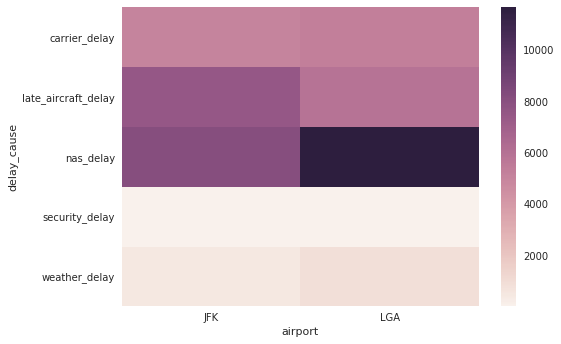

In [21]:
ax = sns.heatmap(arr_del_ind_df4)

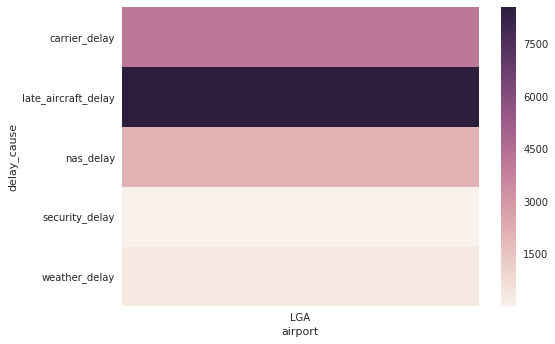

In [22]:
ax = sns.heatmap(dep_del_ind_df4)

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


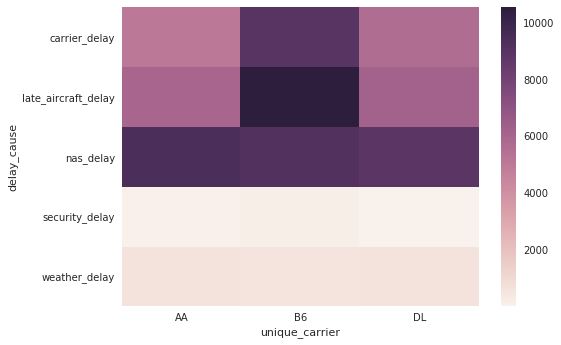

In [15]:
ax = sns.heatmap(arr_del_ind_df3)

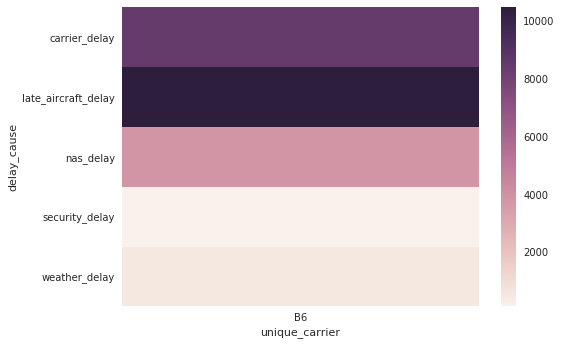

In [17]:
ax = sns.heatmap(dep_del_ind_df3)

In [16]:
ax = sns.heatmap(del_ind_df1)

NameError: name 'del_ind_df1' is not defined

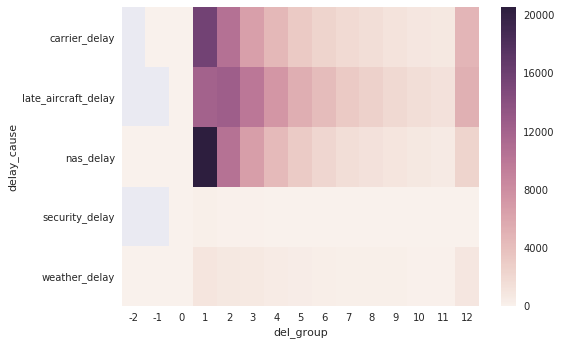

In [66]:
ax = sns.heatmap(del_ind_df2)

In [75]:
// Handle delay_times of zero
ppdf["time_ratio"] = ppdf["taxi_time"]/ppdf["delay_time"]

In [86]:
time_ratio = ppdf["time_ratio"].dropna